In [1]:
!pip install tensorflow keras

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
import pandas as pd

%matplotlib inline

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
data = pd.read_csv('titanic_train.csv', index_col='PassengerId')

useful_cols = ['Survived', 'Pclass', 'Sex', 'Age', 'Fare','SibSp','Parch', 'Embarked' ]
data = data[useful_cols]

print(f'Всего данных: {data.shape[0]}')
data.head(20)

Всего данных: 891


,Survived,Pclass,Sex,Age,Fare,SibSp,Parch,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,7.2500,1,0,S
2,1,1,female,38.0,71.2833,1,0,C
3,1,3,female,26.0,7.9250,0,0,S
4,1,1,female,35.0,53.1000,1,0,S
5,0,3,male,35.0,8.0500,0,0,S
6,0,3,male,NaN,8.4583,0,0,Q
7,0,1,male,54.0,51.8625,0,0,S
8,0,3,male,2.0,21.0750,3,1,S
9,1,3,female,27.0,11.1333,0,2,S


In [3]:
import sklearn.pipeline as pipeline
import sklearn.preprocessing as preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from keras.utils import to_categorical

class FillNa(TransformerMixin, BaseEstimator):
    """
    Удаление пропусков в данных
    """
    
    def fit(self, X: pd.DataFrame, y=None):
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        """
        Убираем пропуски в данных
        """
        return X.interpolate(method='cubic').fillna(method='pad').dropna()
        
    
    
class DropOutlet(TransformerMixin, BaseEstimator):
    """
    Удаление выбросов, основываясь на правиле 3-х сигм (только для нормального распределения)
    """
        
    def fit(self, X: pd.DataFrame, y=None):
        """
        Получаем стандартное отклонение для каждого столбца и сохраняем их        
        """
        self.std = X.std()
        self.columns = self.std.index.values
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        """
        Убираем все здачения, котоые находятся дальше 3-х стандартных отконений (сигма) от мат. ожидания случайной величины
        """
        X_cols = X[self.columns]
        return X[ (X_cols - X_cols.mean()).abs() <= 3*self.std ].dropna()

class PandasToNumpy(BaseEstimator):
    """
    Просто преобразует данные из DataFrame от pandas к матрице от numpy (ndarray)
    """
    
    def fit(self, X : pd.DataFrame = None, y=None):
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> np.ndarray:
        return X.values
    
class SparseToArray(TransformerMixin, BaseEstimator):
    """
    Класс преобразует sparse matrix в ndarray
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.toarray()

class ModifyLabelEncoder(preprocessing.LabelEncoder):
    """
    Стандартный костыль для препроцессора LabelEncoder
    """
    
    def fit(self, X, y=None):
        return super().fit(X)
    
    def transform(self, X, y=None):
        print(1)
        return super().transform(X)
    
    def fit_transform(self, X, y=None):
        return super().fit_transform(X)
    
    
class ExpandDims(TransformerMixin, BaseEstimator):
    """
    Увеличение на 1 рамерности массима в нужной оси
    """
    
    def __init__(self, axis):
        self.axis = axis
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.expand_dims(X, axis=self.axis)

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# Создадим наш pipeline

X_data = data[data.columns[:-1]].copy()
X_data = pd.get_dummies(X_data)

Y_data = data['Survived'].copy()

In [5]:
Y_data

PassengerId
1      0
2      1
3      1
4      1
5      0
6      0
7      0
8      0
9      1
10     1
11     1
12     1
13     0
14     0
15     0
16     1
17     0
18     1
19     0
20     1
21     0
22     1
23     1
24     1
25     0
26     1
27     0
28     0
29     1
30     0
      ..
862    0
863    1
864    0
865    0
866    1
867    1
868    0
869    0
870    1
871    0
872    1
873    0
874    0
875    1
876    1
877    0
878    0
879    0
880    1
881    1
882    0
883    0
884    0
885    0
886    0
887    0
888    1
889    0
890    1
891    0
Name: Survived, Length: 891, dtype: int64

In [6]:
# Создаем препроцессор для заполнения пропусков
fill_na_pipe = pipeline.Pipeline([
    ('fill', FillNa()),
])

pipe_outlet = pipeline.Pipeline([
    ('fill_na', fill_na_pipe),
    ('drop_outlet', DropOutlet()),
])

outletless_data_X = pipe_outlet.fit_transform(X_data)

outletless_data_Y = Y_data[ Y_data.index.isin(outletless_data_X.index) ]

pipe_x = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('norm', preprocessing.MinMaxScaler())
])

pipe_y = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('label_encoder', ModifyLabelEncoder()),
    ('expand_dims', ExpandDims(axis=1)),
    ('one_hot_encoder', preprocessing.OneHotEncoder(sparse=False))
])

number_data_ready_X = pipe_x.fit_transform(outletless_data_X)
number_data_ready_Y = pipe_y.fit_transform(outletless_data_Y)

print(number_data_ready_X.shape, number_data_ready_Y.shape)

(821, 8) (821, 2)


In [7]:
number_data_ready_X[:10,:], number_data_ready_Y[::10]

(array([[0.        , 1.        , 0.37002318, 0.04397492, 0.33333333,
         0.        , 0.        , 1.        ],
        [1.        , 0.        , 0.5638622 , 0.4323693 , 0.33333333,
         0.        , 1.        , 0.        ],
        [1.        , 1.        , 0.41848293, 0.04806914, 0.        ,
         0.        , 1.        , 0.        ],
        [1.        , 0.        , 0.52751738, 0.32207838, 0.33333333,
         0.        , 1.        , 0.        ],
        [0.        , 1.        , 0.52751738, 0.04882733, 0.        ,
         0.        , 0.        , 1.        ],
        [0.        , 1.        , 0.80908601, 0.05130387, 0.        ,
         0.        , 0.        , 1.        ],
        [0.        , 0.        , 0.75770122, 0.31457232, 0.        ,
         0.        , 0.        , 1.        ],
        [0.        , 1.        , 0.1277244 , 0.12783054, 1.        ,
         0.5       , 0.        , 1.        ],
        [1.        , 1.        , 0.43059787, 0.0675291 , 0.        ,
         1.

In [8]:
X_train = number_data_ready_X
Y_train = number_data_ready_Y
X_train.shape, Y_train.shape

((821, 8), (821, 2))

In [30]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras import activations
from keras.optimizers import Adam, RMSprop
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras import callbacks

In [40]:
# Делим в отношении 80/20
XY_data = np.hstack( (number_data_ready_X, number_data_ready_Y) ).transpose((0,1))
np.random.shuffle(XY_data)
# Делим выборки
point_split = round(XY_data.shape[0] * 0.8)
train_data = XY_data[:point_split]
test_data = XY_data[point_split:]
print(f'Всего данных: {XY_data.shape[0]}')
print(f'Тренировочных данных: {train_data.shape[0]}')
print(f'Тестовых данных: {test_data.shape[0]}')
# Делим все на входные и выходные данные
# Тренировочные
X_train = train_data[:, :number_data_ready_X.shape[1] ]
Y_train = train_data[:, number_data_ready_X.shape[1]: ]
print(f'Размер данныx для тренировки (входных): {X_train.shape}')
print(f'Размер данныx для тренировки (выходных): {Y_train.shape}')

# Тестовые
X_test = test_data[:, :number_data_ready_X.shape[1] ]
Y_test = test_data[:, number_data_ready_X.shape[1]: ]
print(f'Размер данных для теста (входных): {X_test.shape}')
print(f'Размер данных для теста (выходных): {Y_test.shape}')

Всего данных: 821
Тренировочных данных: 657
Тестовых данных: 164
Размер данныx для тренировки (входных): (657, 8)
Размер данныx для тренировки (выходных): (657, 2)
Размер данных для теста (входных): (164, 8)
Размер данных для теста (выходных): (164, 2)


In [15]:
def make_nn(input_len, output_len):
    model = Sequential()
    model.add(Dense(10, activation=activations.relu, input_dim=input_len))
    model.add(Dense(output_len, activation=activations.softmax))
    model.compile(Adam(), categorical_crossentropy, metrics=[categorical_accuracy])
    return model

In [41]:
model = make_nn(X_train.shape[1], Y_train.shape[1])

print('Начинаем обучение сети')
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=3,
    epochs=100,
    verbose=1,
    validation_data=(X_test, Y_test),
    callbacks=[
        callbacks.History(),
    ]
    
)

Начинаем обучение сети
Train on 657 samples, validate on 164 samples
Epoch 1/100
657/657 [==============================] - 1s 1ms/step - loss: 0.7700 - categorical_accuracy: 0.6012 - val_loss: 0.3521 - val_categorical_accuracy: 0.9939
Epoch 2/100
657/657 [==============================] - 0s 287us/step - loss: 0.2161 - categorical_accuracy: 1.0000 - val_loss: 0.1363 - val_categorical_accuracy: 1.0000
Epoch 3/100
657/657 [==============================] - 0s 285us/step - loss: 0.0932 - categorical_accuracy: 1.0000 - val_loss: 0.0675 - val_categorical_accuracy: 1.0000
Epoch 4/100
657/657 [==============================] - 0s 249us/step - loss: 0.0489 - categorical_accuracy: 1.0000 - val_loss: 0.0385 - val_categorical_accuracy: 1.0000
Epoch 5/100
657/657 [==============================] - 0s 278us/step - loss: 0.0293 - categorical_accuracy: 1.0000 - val_loss: 0.0244 - val_categorical_accuracy: 1.0000
Epoch 6/100
657/657 [==============================] - 0s 290us/step - loss: 0.0191 - ca

657/657 [==============================] - 0s 278us/step - loss: 1.9545e-05 - categorical_accuracy: 1.0000 - val_loss: 1.8395e-05 - val_categorical_accuracy: 1.0000
Epoch 48/100
657/657 [==============================] - 0s 270us/step - loss: 1.7285e-05 - categorical_accuracy: 1.0000 - val_loss: 1.6232e-05 - val_categorical_accuracy: 1.0000
Epoch 49/100
657/657 [==============================] - 0s 289us/step - loss: 1.5247e-05 - categorical_accuracy: 1.0000 - val_loss: 1.4343e-05 - val_categorical_accuracy: 1.0000
Epoch 50/100
657/657 [==============================] - 0s 271us/step - loss: 1.3466e-05 - categorical_accuracy: 1.0000 - val_loss: 1.2683e-05 - val_categorical_accuracy: 1.0000
Epoch 51/100
657/657 [==============================] - 0s 247us/step - loss: 1.1906e-05 - categorical_accuracy: 1.0000 - val_loss: 1.1188e-05 - val_categorical_accuracy: 1.0000
Epoch 52/100
657/657 [==============================] - 0s 289us/step - loss: 1.0515e-05 - categorical_accuracy: 1.0000 - v

657/657 [==============================] - 0s 281us/step - loss: 1.5468e-07 - categorical_accuracy: 1.0000 - val_loss: 1.4865e-07 - val_categorical_accuracy: 1.0000
Epoch 94/100
657/657 [==============================] - 0s 250us/step - loss: 1.4924e-07 - categorical_accuracy: 1.0000 - val_loss: 1.4501e-07 - val_categorical_accuracy: 1.0000
Epoch 95/100
657/657 [==============================] - 0s 293us/step - loss: 1.4461e-07 - categorical_accuracy: 1.0000 - val_loss: 1.4138e-07 - val_categorical_accuracy: 1.0000
Epoch 96/100
657/657 [==============================] - 0s 277us/step - loss: 1.4035e-07 - categorical_accuracy: 1.0000 - val_loss: 1.3774e-07 - val_categorical_accuracy: 1.0000
Epoch 97/100
657/657 [==============================] - 0s 273us/step - loss: 1.3699e-07 - categorical_accuracy: 1.0000 - val_loss: 1.3447e-07 - val_categorical_accuracy: 1.0000
Epoch 98/100
657/657 [==============================] - 0s 291us/step - loss: 1.3463e-07 - categorical_accuracy: 1.0000 - v

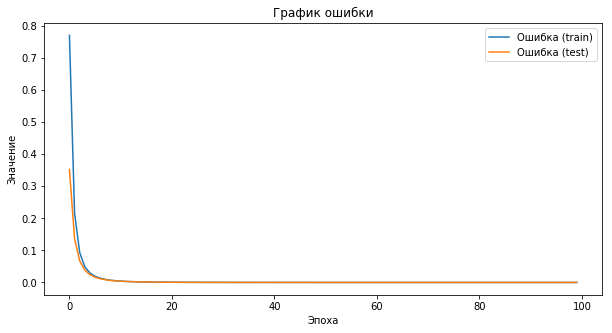

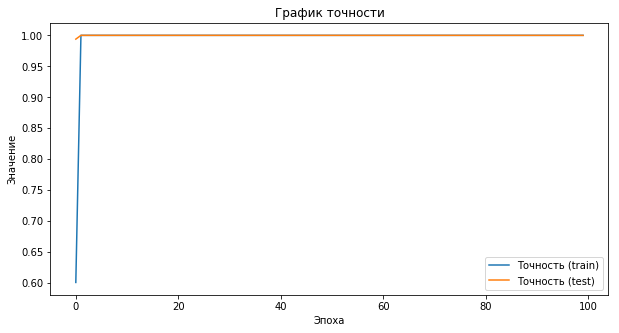

In [42]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

In [18]:
model = make_nn(number_data_ready_X.shape[1], number_data_ready_Y.shape[1])

print('Начинаем обучение сети')
history = model.fit(
    x=number_data_ready_X,
    y=number_data_ready_Y,
    batch_size=3,
    epochs=100,
    verbose=1,
#Вот это разделения данных в соотношении 80/20
    validation_split=0.2,
    callbacks=[
        callbacks.History(),
    ]
    
)

Начинаем обучение сети
Train on 656 samples, validate on 165 samples
Epoch 1/100
656/656 [==============================] - 1s 886us/step - loss: 0.5844 - categorical_accuracy: 0.7271 - val_loss: 0.4411 - val_categorical_accuracy: 0.8364
Epoch 2/100
656/656 [==============================] - 0s 265us/step - loss: 0.3566 - categorical_accuracy: 0.8476 - val_loss: 0.2674 - val_categorical_accuracy: 0.8848
Epoch 3/100
656/656 [==============================] - 0s 238us/step - loss: 0.2128 - categorical_accuracy: 0.9512 - val_loss: 0.1579 - val_categorical_accuracy: 0.9758
Epoch 4/100
656/656 [==============================] - 0s 234us/step - loss: 0.1210 - categorical_accuracy: 0.9924 - val_loss: 0.0874 - val_categorical_accuracy: 1.0000
Epoch 5/100
656/656 [==============================] - 0s 236us/step - loss: 0.0698 - categorical_accuracy: 1.0000 - val_loss: 0.0519 - val_categorical_accuracy: 1.0000
Epoch 6/100
656/656 [==============================] - 0s 238us/step - loss: 0.0428 - 

656/656 [==============================] - 0s 224us/step - loss: 3.1662e-05 - categorical_accuracy: 1.0000 - val_loss: 2.7014e-05 - val_categorical_accuracy: 1.0000
Epoch 48/100
656/656 [==============================] - 0s 229us/step - loss: 2.7977e-05 - categorical_accuracy: 1.0000 - val_loss: 2.3751e-05 - val_categorical_accuracy: 1.0000
Epoch 49/100
656/656 [==============================] - 0s 254us/step - loss: 2.4412e-05 - categorical_accuracy: 1.0000 - val_loss: 2.0631e-05 - val_categorical_accuracy: 1.0000
Epoch 50/100
656/656 [==============================] - 0s 239us/step - loss: 2.1030e-05 - categorical_accuracy: 1.0000 - val_loss: 1.7819e-05 - val_categorical_accuracy: 1.0000
Epoch 51/100
656/656 [==============================] - 0s 219us/step - loss: 1.8030e-05 - categorical_accuracy: 1.0000 - val_loss: 1.5463e-05 - val_categorical_accuracy: 1.0000
Epoch 52/100
656/656 [==============================] - 0s 259us/step - loss: 1.5534e-05 - categorical_accuracy: 1.0000 - v

656/656 [==============================] - 0s 245us/step - loss: 1.8163e-07 - categorical_accuracy: 1.0000 - val_loss: 1.7954e-07 - val_categorical_accuracy: 1.0000
Epoch 94/100
656/656 [==============================] - 0s 229us/step - loss: 1.7173e-07 - categorical_accuracy: 1.0000 - val_loss: 1.7123e-07 - val_categorical_accuracy: 1.0000
Epoch 95/100
656/656 [==============================] - 0s 252us/step - loss: 1.6400e-07 - categorical_accuracy: 1.0000 - val_loss: 1.6184e-07 - val_categorical_accuracy: 1.0000
Epoch 96/100
656/656 [==============================] - 0s 252us/step - loss: 1.5719e-07 - categorical_accuracy: 1.0000 - val_loss: 1.5533e-07 - val_categorical_accuracy: 1.0000
Epoch 97/100
656/656 [==============================] - 0s 231us/step - loss: 1.5074e-07 - categorical_accuracy: 1.0000 - val_loss: 1.4955e-07 - val_categorical_accuracy: 1.0000
Epoch 98/100
656/656 [==============================] - 0s 230us/step - loss: 1.4610e-07 - categorical_accuracy: 1.0000 - v

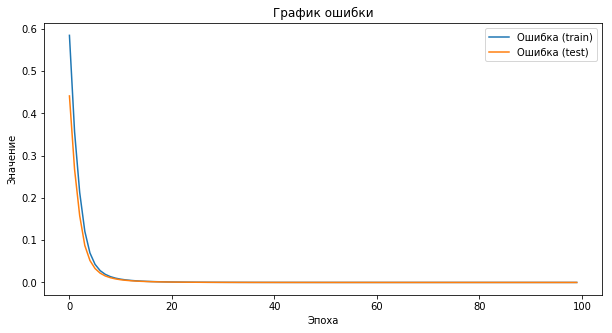

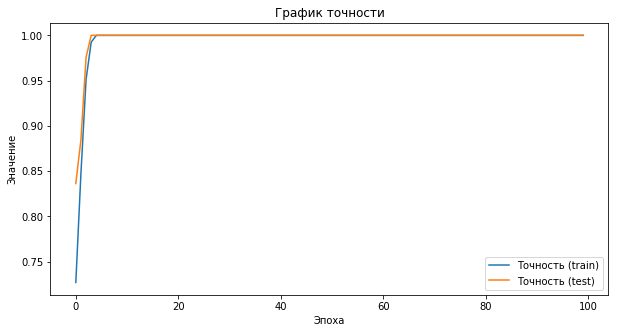

In [19]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

In [20]:
from pathlib import Path
from os import remove

# создадим функцию создания о очисти каталога контрольных точек
# указываем шаблон имени фала контрольной точки
file_name = 'nn_model_loss-{loss:.2f}_val_loss-{val_loss:.2f}_acc-{categorical_accuracy:.2f}_val_acc-{val_categorical_accuracy:.2f}.hdf5'
def make_save_points(name='save_points', file_name=file_name):
#     выбираем катагол (подробнее https://docs.python.org/3.6/library/pathlib.html ) 
    checkpoints_dir = Path('./').joinpath('save_points')
    print(f'Текущий каталог с контрольными точками {checkpoints_dir.absolute()}')
    # Создаем каталог если его нету
    checkpoints_dir.mkdir(exist_ok=True)
    # Удаляем все из каталога
    for item in checkpoints_dir.iterdir():
        if item.is_file():
            print(f'Удаляем файл {item}')
            remove(item)
    return str(checkpoints_dir.joinpath(file_name))

In [32]:
print('Начинаем обучение сети')
history = make_nn(X_train.shape[1], Y_train.shape[1]).fit(
    x=X_train,
    y=Y_train,
    batch_size=3,
    epochs=100,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        callbacks.History(),
# Callback сохранений состояний сети
        callbacks.ModelCheckpoint(
# Указываем путь для сохранения и формат имен файлов
            make_save_points(file_name=file_name),
# Указываем какое значение отслеживать
            monitor='val_categorical_accuracy',
# Указываем, что сохранять надо только лучшие результаты
            save_best_only=True,
# Говорим как часто проверять, что текущий результат лучше предыдущего (в эпохах)
            period=5,
#Указываем сторону лучших значений
            mode='max'
        )
    ]
)

Начинаем обучение сети
Текущий каталог с контрольными точками C:\Users\TEMP.EDU.023\save_points
Удаляем файл save_points\nn_model_loss-0.28_val_loss-0.30_acc-0.82_val_acc-0.89.hdf5
Удаляем файл save_points\nn_model_loss-0.29_val_loss-0.30_acc-0.81_val_acc-0.83.hdf5
Удаляем файл save_points\nn_model_loss-0.29_val_loss-0.30_acc-0.82_val_acc-0.83.hdf5
Удаляем файл save_points\nn_model_loss-0.29_val_loss-0.30_acc-0.82_val_acc-0.85.hdf5
Удаляем файл save_points\nn_model_loss-0.37_val_loss-0.37_acc-0.85_val_acc-0.83.hdf5
Train on 525 samples, validate on 132 samples
Epoch 1/100
525/525 [==============================] - 1s 1ms/step - loss: 0.5967 - categorical_accuracy: 0.7752 - val_loss: 0.4826 - val_categorical_accuracy: 0.7803
Epoch 2/100
525/525 [==============================] - 0s 287us/step - loss: 0.4878 - categorical_accuracy: 0.8038 - val_loss: 0.4026 - val_categorical_accuracy: 0.8258
Epoch 3/100
525/525 [==============================] - 0s 259us/step - loss: 0.4247 - categorical

Epoch 46/100
525/525 [==============================] - 0s 260us/step - loss: 0.3023 - categorical_accuracy: 0.8324 - val_loss: 0.2347 - val_categorical_accuracy: 0.8409
Epoch 47/100
525/525 [==============================] - 0s 272us/step - loss: 0.3022 - categorical_accuracy: 0.8229 - val_loss: 0.2346 - val_categorical_accuracy: 0.9242
Epoch 48/100
525/525 [==============================] - 0s 253us/step - loss: 0.3022 - categorical_accuracy: 0.8267 - val_loss: 0.2346 - val_categorical_accuracy: 0.9091
Epoch 49/100
525/525 [==============================] - 0s 293us/step - loss: 0.3021 - categorical_accuracy: 0.8305 - val_loss: 0.2347 - val_categorical_accuracy: 0.9394
Epoch 50/100
525/525 [==============================] - 0s 260us/step - loss: 0.3021 - categorical_accuracy: 0.8267 - val_loss: 0.2345 - val_categorical_accuracy: 0.8712
Epoch 51/100
525/525 [==============================] - 0s 254us/step - loss: 0.3020 - categorical_accuracy: 0.8152 - val_loss: 0.2345 - val_categoric

525/525 [==============================] - 0s 265us/step - loss: 0.3016 - categorical_accuracy: 0.8857 - val_loss: 0.2340 - val_categorical_accuracy: 0.9848
Epoch 95/100
525/525 [==============================] - 0s 283us/step - loss: 0.3016 - categorical_accuracy: 0.8990 - val_loss: 0.2341 - val_categorical_accuracy: 0.8864
Epoch 96/100
525/525 [==============================] - 0s 263us/step - loss: 0.3017 - categorical_accuracy: 0.8800 - val_loss: 0.2345 - val_categorical_accuracy: 0.9848
Epoch 97/100
525/525 [==============================] - 0s 265us/step - loss: 0.3016 - categorical_accuracy: 0.8819 - val_loss: 0.2339 - val_categorical_accuracy: 0.9848
Epoch 98/100
525/525 [==============================] - 0s 264us/step - loss: 0.3016 - categorical_accuracy: 0.8876 - val_loss: 0.2339 - val_categorical_accuracy: 0.9394
Epoch 99/100
525/525 [==============================] - 0s 255us/step - loss: 0.3016 - categorical_accuracy: 0.8667 - val_loss: 0.2339 - val_categorical_accuracy: 

In [34]:
from keras.models import load_model

# Загружаем контрольную точку (модель)
# Обратите внимание путь до контрольной точки может отличатся
loaded_model = load_model('./save_points/nn_model_loss-0.36_val_loss-0.29_acc-0.81_val_acc-0.82.hdf5')

# Прeдсказываем класс
print(f'Точность предсказания на тренировочных данных {loaded_model.evaluate(X_train, Y_train)[1]}')
print(f'Точность предсказания на тестовых данных {loaded_model.evaluate(X_test, Y_test)[1]}')
predict = loaded_model.predict_classes(X_test)
predict

657/657 [==============================] - 0s 247us/step
Точность предсказания на тренировочных данных 0.8219178083099006
164/164 [==============================] - 0s 24us/step
Точность предсказания на тестовых данных 0.8292682926829268


array([0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1], dtype=int64)

In [36]:
# Прeдсказываем вероятности для классов
loaded_model.predict(X_train)

array([[0.1264692 , 0.8735308 ],
       [0.12043454, 0.87956554],
       [0.08389015, 0.91610986],
       ...,
       [0.04299365, 0.9570064 ],
       [0.0496566 , 0.9503434 ],
       [0.05116854, 0.9488314 ]], dtype=float32)